# amPPL

> A modest probabilistic programming language (PPL) I threw together because I wanted to be able to use JAX to evaluate likelihoods, but was making way too many mistakes when writing likelihoods.

## Install

`pip install your_project_name`

## How to use

In [ ]:
import numpy
import scipy
import scipy.stats

from matplotlib import pyplot
import seaborn
from tqdm import tqdm
import jax.scipy as jsc
import jax.numpy as jnp
from jax import grad, jit, value_and_grad

from jax.experimental import optimizers

/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [ ]:
from amppl.model import Model, ModelBase


Let's generate some data that follows a simple linear model of the form

$$y= -\frac{1}{2}X + 5$$

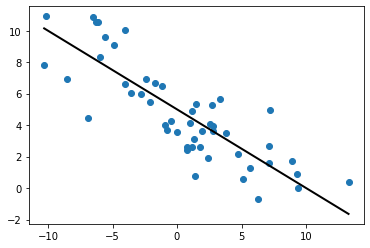

In [ ]:
X=scipy.stats.norm.rvs(0, 5, size=50)
beta0, beta1=5, -.5

def lin_fxn(X, beta0, beta1):
    return X*beta1+beta0
y_true=lin_fxn(X, beta0, beta1)
sd=1.5
err= scipy.stats.norm.rvs(0,sd, size=len(X))

y_obs=y_true+err

pyplot.scatter(X,y_obs, )
domain=numpy.linspace(X.min(),X.max(), 100)
pyplot.plot(domain, lin_fxn(domain, beta0, beta1), c='black', lw=2 )

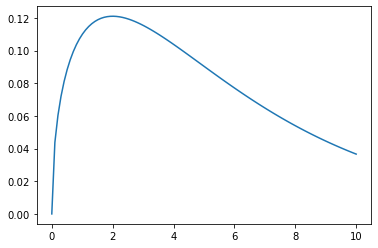

In [ ]:
err_val=numpy.linspace(0,10,100)

pyplot.plot(err_val,numpy.exp(jsc.stats.gamma.logpdf(err_val, a=1.5,loc=0, scale=4)))

I want to be able to define the model in terms of probability distributions without have to keep track of any of the math. Normally I would use PyMC3 for this sort of task. However, sometimes when I have a very large dataset or a complicated model I want the flexibility to be able to do my own optimization, using JAX to compute the gradients.

We can specify models in a similar manner to pyMC. We need to create a class using `ModelBase` as a template and using the `@Model` decorator. The decorator runs some initialization code. We define the model's structure by including a  method named `model`. This, counterintuitively, should not return values. Rather, all of the computed probabilities will be stored internally.

In [ ]:
@Model
class LinearModel(ModelBase):
    def model(self, *args, **kwargs):
        #Define the priors
        beta=self.Normal('beta', shape=2, loc=0,scale=10)
        err=self.Gamma('err', a=1.5, scale=4)
        
        #Compute the predicted values of Y
        y_pred=lin_fxn(X, beta[0], beta[1])
        
        #Define the likelihood by creating an RV with a predefined value equal to y_obs
        obs=self.Normal('Y_obs', 
                    value=y_obs, loc=y_pred, scale=err)

By building the class around the `ModelBase` template, we have access to a number of methods that we don't need to explicitly define. The principal method we need to define the model is the `ModelBase.RV` function. This adds parameters to the model when `model` is first called, stores the probability of the current value of each parameter, and returns current value of the parameter. This is wrapped for a number of predefined distributions in the `DistributionDefinitions` base class, on which `ModelBase` is built. So, when write

```python
        beta=self.Normal('beta', shape=2, loc=0,scale=10)
```

under the surface the model

1. Looks up the current value of `beta` stored in its internal state. If the variable doesn't exist, it creates it.

2. Computes the log-probability of the current value under a Normal distribution with mean of 0 and standard deviation of 10. It stores this internally.

3. Return the current value of `beta`. This way, we can perform mathematical operations with `beta` and pass the results to other probability distributions.

The model always works with unconstrained representations of its parameters and stores them as an array. That is `err` follows a Gamma distribution and must always be positive. So, the model works with the log of `err`. If we want to create an array of the appropriate size for this internal state, we can use `generate_vector`.

In [ ]:
x0=LinearModel.generate_vector()

And we can pass this to the model with `ModelBase.set_state_and_evaluate` to get the associated probability.

In [ ]:
LinearModel.set_state_and_evaluate(x0)

DeviceArray(-834.9497, dtype=float32)

This also sets the model's internal state. We can access the corresponding (constrained) model parameters in the `.parameters` attribute

In [ ]:
LinearModel.parameters

{'beta': DeviceArray([0., 0.], dtype=float32),
 'err': DeviceArray([1.], dtype=float32),
 'Y_obs': DeviceArray([0.], dtype=float32)}

If we want to perform gradient descent, we can import the `Optimizer` class from the `optimizers` submodule:

In [ ]:
from amppl.optimizers import Optimizer

In [ ]:
opt=Optimizer(LinearModel)

In [ ]:
opt.fit(500)

 28%|██▊       | 138/500 [00:01<00:04, 80.08it/s] 


converged


The above model has two kinds of RV:
    
1. RVs that do not have their values defined (`beta` and `err`). These are free parameters whose values we will try to estimate.

1. RVs that have a defined value using the `value` argument (`obs`). These are not 

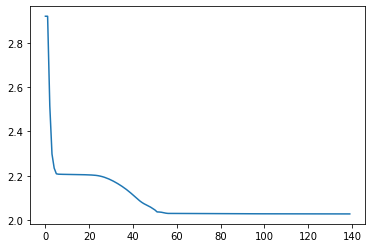

In [ ]:
pyplot.plot(numpy.log10(opt.hist))

We can check fitted model parameters using `.vector2values`

In [ ]:
fitted_params=opt.parameters

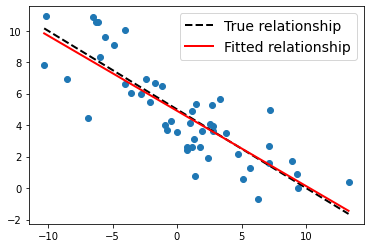

In [ ]:
pyplot.scatter(X,y_obs, )
domain=numpy.linspace(X.min(),X.max(), 100)
pyplot.plot(domain, lin_fxn(domain, beta0, beta1), c='black', lw=2, ls='--', label='True relationship' )
pyplot.plot(domain, lin_fxn(domain, fitted_params['beta'][0], fitted_params['beta'][1]), 
            c='red', lw=2, ls='-', label='Fitted relationship' )
pyplot.legend(fontsize=14)

Let's see how this compares to the results from fitting the regression with scipy

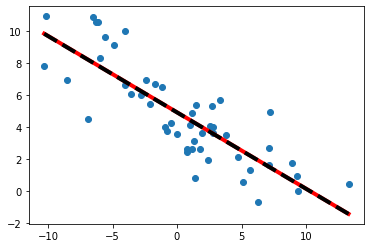

In [ ]:
linreg=scipy.stats.linregress(x=X, y=y_obs)

pyplot.plot(domain, lin_fxn(domain, fitted_params['beta'][0], fitted_params['beta'][1]), c='red', lw=4, ls='-' )
pyplot.plot(domain, lin_fxn(domain, linreg.intercept, linreg.slope), c='black', lw=4, ls='--' )
pyplot.scatter(X,y_obs, )


### A more complicated example

Instead, we could generate a million data points from a hierarchical model where each data point comes from one of 100 different groups, each with its own slope and intercept. These slopes and intercepts, however, each arise from normal distributions with unknown means and variances.

In [ ]:



ndata=1000000
ngroups=100
X=scipy.stats.norm.rvs(0,2.5, size=ndata)
group=numpy.repeat(numpy.arange(ngroups), ndata/ngroups).astype(int)
beta1=scipy.stats.norm.rvs(2,.7, size=ngroups)
beta0=scipy.stats.norm.rvs(-3,1, size=ngroups)
err=scipy.stats.norm.rvs(0,2, size=ndata)
Y=X*beta1[group]+beta0[group]+err

In [ ]:
@Model
class HierarchicalModel(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        mean_0=self.Normal('mean_0',loc=0, scale=5 )
        mean_1=self.Normal('mean_1',loc=0, scale=5 )
        
        #define the hyperpriors for the standard deviation of the coefficients across groups
        sd_0=self.Gamma('sd_0',a=1, scale=3 )
        sd_1=self.Gamma('sd_1',a=1, scale=3)
        
        #define the priors on the regression coefficients for each group
        beta_0=self.Normal('beta_0',shape=ngroups,loc=mean_0, scale=sd_0 )
        beta_1=self.Normal('beta_1',shape=ngroups,loc=mean_1, scale=sd_1 )
        
        #define the prior on the residuals
        err=self.Gamma('err',a=1, loc=0, scale=3)
        
        # compute the model's predictions of Y given the coefficients
        y_pred=beta_0[group]+beta_1[group]*X

        # Evaluate the likelihood of the observed data
        obs=self.Normal('Y', value=Y,loc=y_pred, scale=err)

In [ ]:
hier_opt=Optimizer(HierarchicalModel)

In [ ]:
hier_opt.fit(10000)

  2%|▏         | 179/10000 [00:09<08:49, 18.54it/s]


converged


In [ ]:
fitted_params=hier_opt.parameters
fitted_params

{'mean_0': DeviceArray([-3.0275288], dtype=float32),
 'mean_1': DeviceArray([2.020991], dtype=float32),
 'sd_0': DeviceArray([1.0941724], dtype=float32),
 'sd_1': DeviceArray([0.68089664], dtype=float32),
 'beta_0': DeviceArray([-4.316723  , -4.867665  , -3.1895487 , -3.7780404 ,
              -1.6583544 , -2.4050782 , -2.832611  , -0.53006023,
              -5.180252  , -1.6921668 , -2.410972  , -3.859686  ,
              -4.4734006 , -3.6447725 ,  0.05769765, -2.4787798 ,
              -4.4526343 , -3.4796052 , -4.1074085 , -3.0168548 ,
              -4.147661  , -2.4707358 , -0.6563314 , -3.4533772 ,
              -4.301347  , -0.56569916, -4.108191  , -3.2579992 ,
              -3.5012913 , -2.7981737 , -1.5055044 , -3.8736591 ,
              -1.3319268 , -2.8259993 , -2.1871047 , -3.1553109 ,
              -2.7404535 , -2.5795298 , -3.7508533 , -4.5092816 ,
              -2.54825   , -3.9311767 , -2.727492  , -3.3213854 ,
              -1.8175871 , -3.735491  , -4.58906   , -4.076

Let's check whether we've recovered the hyperparameters:

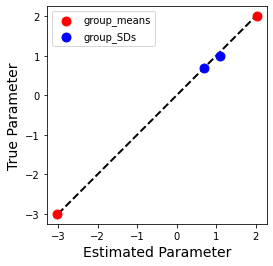

In [ ]:
pyplot.scatter([fitted_params['mean_0'],fitted_params['mean_1']],[-3, 2],s=80, c='r', label='group_means' )
pyplot.scatter([fitted_params['sd_0'],fitted_params['sd_1']],[1, .7],s=80, c='b', label='group_SDs' )
pyplot.plot([-3,2],[-3,2], c='black', lw=2, zorder=-1, ls='--')
pyplot.gca().set_aspect('equal')
pyplot.ylabel('True Parameter', size=14)
pyplot.xlabel('Estimated Parameter', size=14)
pyplot.legend()

Yup, we have.

Text(0.5, 0, 'Estimated Parameter')

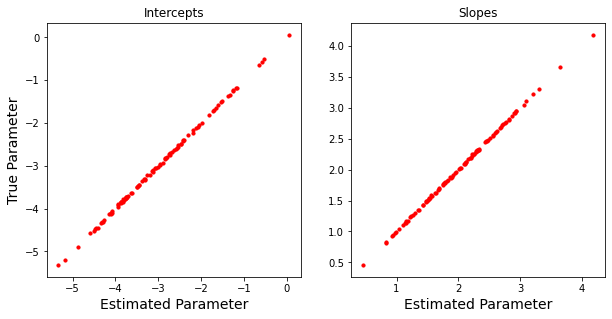

In [ ]:
pyplot.figure(figsize=(10,5))
pyplot.subplot(121)
pyplot.scatter(fitted_params['beta_0'],beta0,s=10, c='r')
# pyplot.plot([-3,2],[-3,2], c='black', lw=2, zorder=-1, ls='--')
pyplot.gca().set_aspect('equal')
pyplot.ylabel('True Parameter', size=14)
pyplot.xlabel('Estimated Parameter', size=14)
pyplot.title('Intercepts')
pyplot.subplot(122)
pyplot.scatter(fitted_params['beta_1'],beta1,s=10, c='r')
# pyplot.plot([-3,2],[-3,2], c='black', lw=2, zorder=-1, ls='--')
pyplot.gca().set_aspect('equal')
pyplot.title('Slopes')
pyplot.xlabel('Estimated Parameter', size=14)

Note, that this kind of hierarchical model can be nonrobust with respect to optimization if the number of observations per group is small. The posterior volume associated with a given hyperparameter value needs to be accounted for.